## Imports & Path

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)
sns.set_context("notebook")

DATA_DIR = Path(r"C:\Users\Playdata\Documents\eda-playground\data")
assert DATA_DIR.exists(), f"DATA_DIR not found: {DATA_DIR}"

DATA_PATH = Path(r"C:\Users\Playdata\Documents\eda-playground\data\happiness_2015_2024.csv")
assert DATA_PATH.exists(), f"DATA_PATH not found: {DATA_PATH}"


## Load + Standardize + Integrate (2015~2024)

In [2]:
STANDARD_COLS = [
    "year", "country", "region", "rank", "score",
    "gdp_per_capita", "social_support", "healthy_life_expectancy",
    "freedom", "generosity", "perceptions_of_corruption",
    "upperwhisker", "lowerwhisker",
    "standard_error", "lower_confidence_interval", "upper_confidence_interval",
    "dystopia_residual",
]

def clean_country_name(country_s: pd.Series) -> pd.Series:
    """
    국가명 문자열의 최소 정규화를 수행한다.

    - 좌우 공백 제거
    - 다중 공백 축소
    - 일부 데이터에 포함된 '*' 제거 (예: 'Luxembourg*' -> 'Luxembourg')
    """
    s = country_s.astype(str).str.strip()
    s = s.str.replace(r"\s+", " ", regex=True)
    s = s.str.replace("*", "", regex=False)
    return s

# =========================
# ✅ 팀원이 합쳐둔 CSV 하나만 로드
# =========================
happiness_df = pd.read_csv(DATA_PATH)

# 합쳐진 CSV에서 사용하는 컬럼명 보정: corruption -> perceptions_of_corruption
if "corruption" in happiness_df.columns and "perceptions_of_corruption" not in happiness_df.columns:
    happiness_df = happiness_df.rename(columns={"corruption": "perceptions_of_corruption"})

# country 최소 정규화
if "country" in happiness_df.columns:
    happiness_df["country"] = clean_country_name(happiness_df["country"])

# region은 합쳐진 CSV에 없을 수 있으므로 표준 컬럼에 맞춰 생성
for col in STANDARD_COLS:
    if col not in happiness_df.columns:
        happiness_df[col] = np.nan

# 컬럼 순서 고정
happiness_df = happiness_df[STANDARD_COLS]

# 숫자형 캐스팅(핵심 분석 컬럼)
numeric_cols = [
    "year", "rank", "score",
    "gdp_per_capita", "social_support", "healthy_life_expectancy",
    "freedom", "generosity", "perceptions_of_corruption",
    "upperwhisker", "lowerwhisker",
    "standard_error", "lower_confidence_interval", "upper_confidence_interval",
    "dystopia_residual",
]
for c in numeric_cols:
    happiness_df[c] = pd.to_numeric(happiness_df[c], errors="coerce")

print("shape:", happiness_df.shape)
display(happiness_df.head())


shape: (1510, 17)


,year,country,region,rank,score,gdp_per_capita,social_support,healthy_life_expectancy,freedom,generosity,perceptions_of_corruption,upperwhisker,lowerwhisker,standard_error,lower_confidence_interval,upper_confidence_interval,dystopia_residual
0,2015,Switzerland,NaN,1,7.587,1.39651,1.34951,0.94143,0.66557,0.29678,0.41978,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,Iceland,NaN,2,7.561,1.30232,1.40223,0.94784,0.62877,0.43630,0.14145,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,Denmark,NaN,3,7.527,1.32548,1.36058,0.87464,0.64938,0.34139,0.48357,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,Norway,NaN,4,7.522,1.45900,1.33095,0.88521,0.66973,0.34699,0.36503,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,Canada,NaN,5,7.427,1.32629,1.32261,0.90563,0.63297,0.45811,0.32957,NaN,NaN,NaN,NaN,NaN,NaN


## 연도별 국가 수 / 중복

In [3]:
year_country_cnt_df = (
    happiness_df.groupby("year")["country"]
    .nunique()
    .reset_index(name="n_countries")
    .sort_values("year")
)
display(year_country_cnt_df)

dup_df = (
    happiness_df.groupby(["year", "country"])
    .size()
    .reset_index(name="cnt")
    .query("cnt > 1")
)
print("duplicate rows (year-country):", len(dup_df))
display(dup_df.head(20))

,year,n_countries
0,2015,158
1,2016,157
2,2017,155
3,2018,156
4,2019,156
5,2020,153
6,2021,149
7,2022,146
8,2023,137
9,2024,143


duplicate rows (year-country): 0


,year,country,cnt


## 변동성 Top N 국가 분석 (Score/Rank)

### 국가별 변동성 지표 만들기
- rank_jump_mean: 연도 간 평균 |Δrank|
- rank_jump_max: 연도 간 최대 |Δrank|
- rank_std, score_std: 기간 전체 표준편차
- delta_2015_2024_*: 2015→2024 변화량(가능한 경우)

In [4]:
def build_volatility_metrics(happiness_df: pd.DataFrame) -> pd.DataFrame:
    """
    국가별 행복지수 변동성(순위/점수)의 요약 지표를 계산한다.

    Metrics
    -------
    - n_years: 관측된 연도 수
    - rank_jump_mean: 연도 간 평균 |Δrank|
    - rank_jump_max: 연도 간 최대 |Δrank|
    - rank_std: 전체 기간 rank 표준편차
    - score_std: 전체 기간 score 표준편차
    - delta_2015_2024_rank: 2024 rank - 2015 rank (음수면 순위 개선)
    - delta_2015_2024_score: 2024 score - 2015 score

    Parameters
    ----------
    happiness_df : pd.DataFrame
        통합/표준화된 데이터프레임(연도, 국가, rank, score 포함).

    Returns
    -------
    pd.DataFrame
        국가별 변동성 지표 데이터프레임.
    """
    years = sorted(happiness_df["year"].unique())
    panel_rank_df = happiness_df.pivot_table(index="country", columns="year", values="rank", aggfunc="mean")
    panel_score_df = happiness_df.pivot_table(index="country", columns="year", values="score", aggfunc="mean")

    rank_diff_df = panel_rank_df[years].diff(axis=1).abs()

    vol_df = pd.DataFrame(index=panel_rank_df.index)
    vol_df["n_years"] = panel_rank_df.notna().sum(axis=1)
    vol_df["rank_jump_mean"] = rank_diff_df.mean(axis=1, skipna=True)
    vol_df["rank_jump_max"] = rank_diff_df.max(axis=1, skipna=True)
    vol_df["rank_std"] = panel_rank_df.std(axis=1, skipna=True)
    vol_df["score_std"] = panel_score_df.std(axis=1, skipna=True)

    if 2015 in panel_rank_df.columns and 2024 in panel_rank_df.columns:
        vol_df["delta_2015_2024_rank"] = panel_rank_df[2024] - panel_rank_df[2015]  # (-)면 순위 개선
    if 2015 in panel_score_df.columns and 2024 in panel_score_df.columns:
        vol_df["delta_2015_2024_score"] = panel_score_df[2024] - panel_score_df[2015]

    return vol_df.reset_index().rename(columns={"index": "country"})

volatility_df = build_volatility_metrics(happiness_df)
display(volatility_df.sort_values("rank_jump_mean", ascending=False).head(10))

,country,n_years,rank_jump_mean,rank_jump_max,rank_std,score_std,delta_2015_2024_rank,delta_2015_2024_score
2,Algeria,10,14.777778,31.0,21.704070,0.437445,17.0,-0.241
173,Venezuela,10,14.666667,38.0,29.051678,0.662739,56.0,-1.203
87,Liberia,10,13.444444,34.0,17.400192,0.542713,5.0,-0.302
53,Gambia,6,12.000000,26.0,11.160944,0.345827,NaN,NaN
139,Somalia,4,12.000000,17.0,14.863266,0.322712,NaN,NaN
113,Nigeria,10,11.777778,30.0,13.571211,0.239627,24.0,-0.387
119,Pakistan,10,11.666667,39.0,19.287590,0.433600,27.0,-0.537
94,Malaysia,10,11.555556,45.0,16.850981,0.340180,-2.0,0.205
85,Lebanon,10,11.444444,22.0,23.952731,1.156797,39.0,-2.132
14,Benin,10,11.000000,34.0,23.647645,0.656689,-39.0,1.037


### 변동성 Top 15 시각화

,country,n_years,rank_jump_mean,rank_jump_max,rank_std,score_std,delta_2015_2024_rank,delta_2015_2024_score
2,Algeria,10,14.777778,31.0,21.704070,0.437445,17.0,-0.241
173,Venezuela,10,14.666667,38.0,29.051678,0.662739,56.0,-1.203
87,Liberia,10,13.444444,34.0,17.400192,0.542713,5.0,-0.302
53,Gambia,6,12.000000,26.0,11.160944,0.345827,NaN,NaN
113,Nigeria,10,11.777778,30.0,13.571211,0.239627,24.0,-0.387
119,Pakistan,10,11.666667,39.0,19.287590,0.433600,27.0,-0.537
94,Malaysia,10,11.555556,45.0,16.850981,0.340180,-2.0,0.205
85,Lebanon,10,11.444444,22.0,23.952731,1.156797,39.0,-2.132
14,Benin,10,11.000000,34.0,23.647645,0.656689,-39.0,1.037
56,Ghana,10,10.444444,23.0,12.896597,0.359142,6.0,-0.344


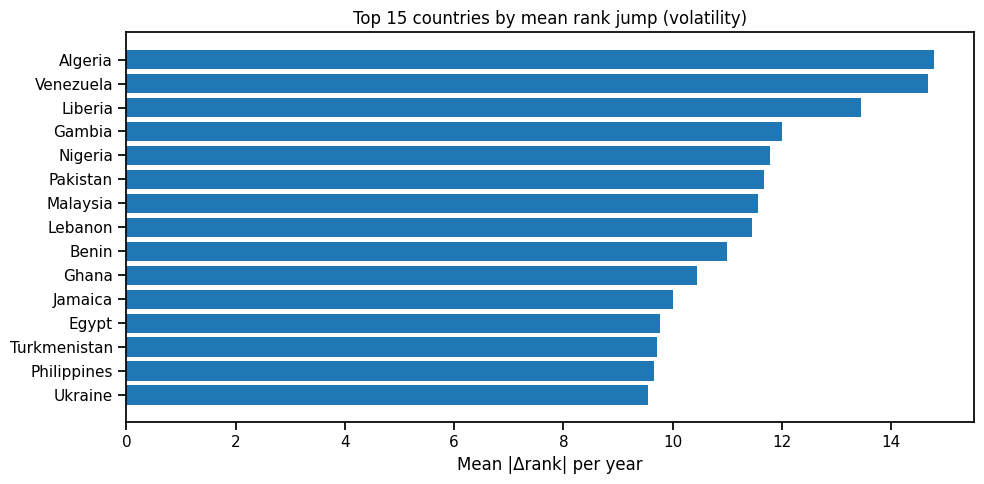

In [5]:
TOP_N = 15  # 여기만 바꾸면 됨

top_vol_df = (
    volatility_df.dropna(subset=["rank_jump_mean"])
    .query("n_years >= 6")  # 관측 연도 너무 적은 국가는 제외(원하면 조정)
    .sort_values("rank_jump_mean", ascending=False)
    .head(TOP_N)
)

display(top_vol_df[[
    "country", "n_years", "rank_jump_mean", "rank_jump_max", "rank_std", "score_std",
    "delta_2015_2024_rank", "delta_2015_2024_score"
]])

plt.figure(figsize=(10, 5))
plt.barh(top_vol_df["country"], top_vol_df["rank_jump_mean"])
plt.title(f"Top {TOP_N} countries by mean rank jump (volatility)")
plt.xlabel("Mean |Δrank| per year")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Top 15 국가의 “시간 흐름(순위/점수)” 확인(라인 차트)

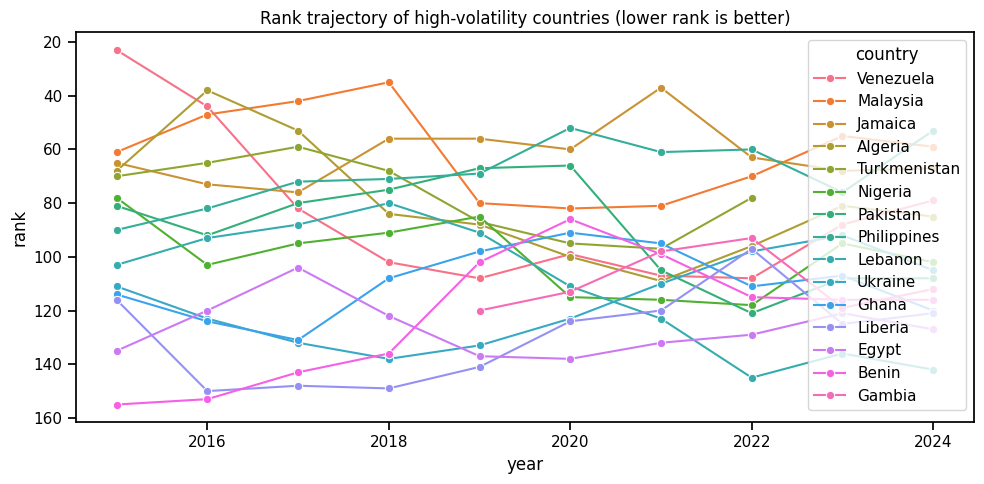

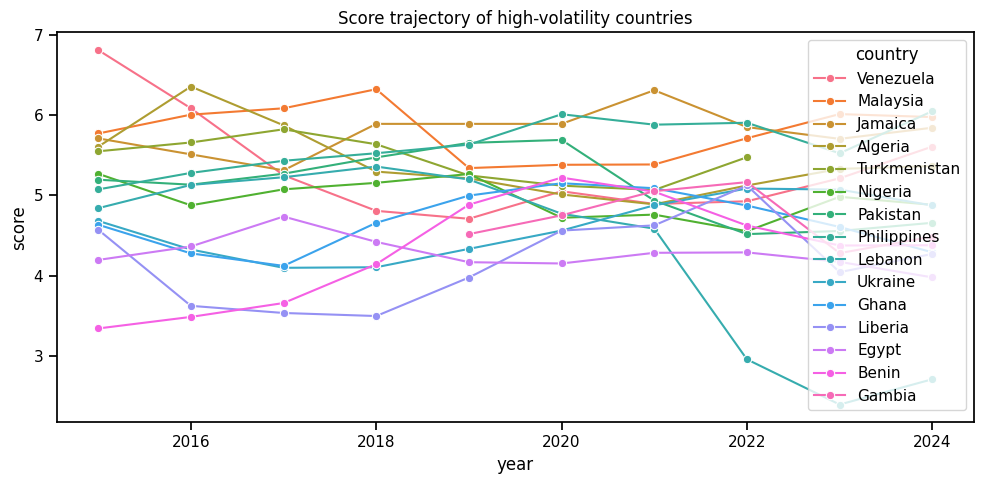

In [6]:
focus_countries = top_vol_df["country"].tolist()

focus_df = happiness_df[happiness_df["country"].isin(focus_countries)].copy()

plt.figure(figsize=(10, 5))
sns.lineplot(data=focus_df, x="year", y="rank", hue="country", marker="o")
plt.gca().invert_yaxis()
plt.title("Rank trajectory of high-volatility countries (lower rank is better)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.lineplot(data=focus_df, x="year", y="score", hue="country", marker="o")
plt.title("Score trajectory of high-volatility countries")
plt.tight_layout()
plt.show()

## 코로나 전/후 비교 (2015–2019 vs 2020–2024)

### 분포 비교: KDE + Boxplot + 분산/꼬리 지표

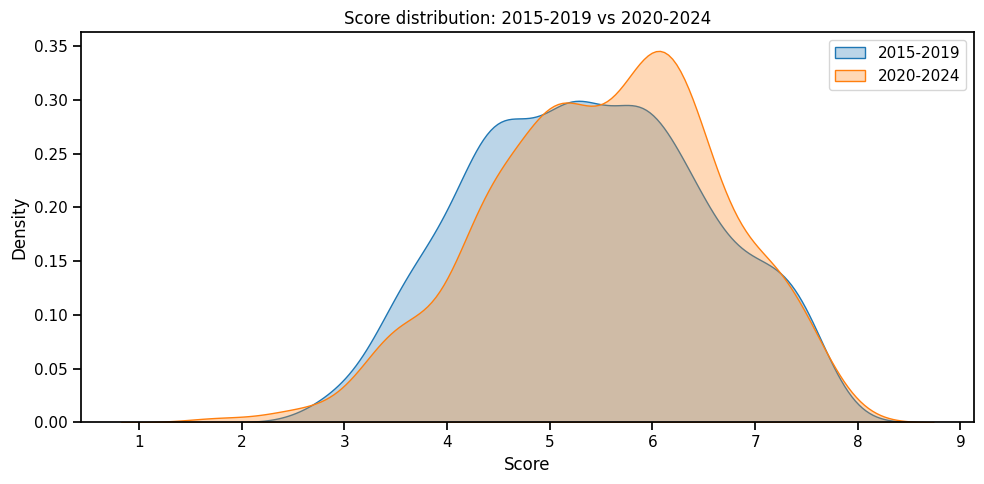

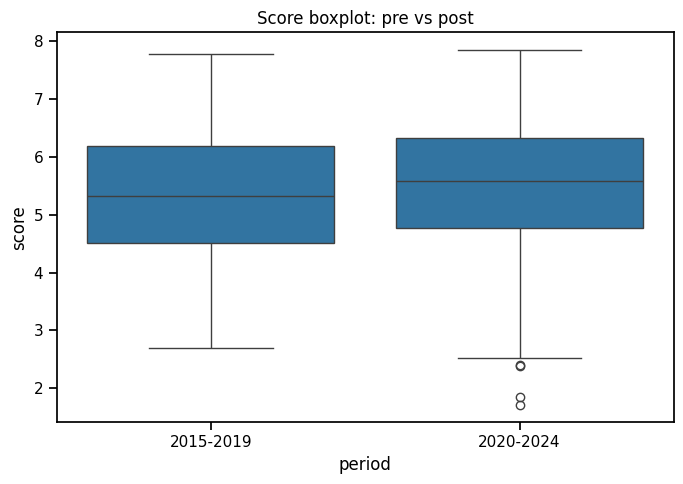

,n,mean,std,q10,q50,q90,iqr,skew,kurtosis
2015-2019,782,5.379018,1.127456,3.8771,5.322,6.9637,1.67975,0.035791,-0.763860
2020-2024,728,5.524740,1.113797,4.1176,5.583,6.9686,1.55550,-0.294586,-0.254074


mean(post) - mean(pre): 0.14572248161671464
t-test: TtestResult(statistic=np.float64(-2.5254153695587505), pvalue=np.float64(0.011658280287768502), df=np.float64(1502.69257497097))


In [7]:
pre_df = happiness_df[(happiness_df["year"] >= 2015) & (happiness_df["year"] <= 2019)].dropna(subset=["score"]).copy()
post_df = happiness_df[(happiness_df["year"] >= 2020) & (happiness_df["year"] <= 2024)].dropna(subset=["score"]).copy()

# (1) KDE
plt.figure(figsize=(10, 5))
sns.kdeplot(pre_df["score"], label="2015-2019", fill=True, alpha=0.3)
sns.kdeplot(post_df["score"], label="2020-2024", fill=True, alpha=0.3)
plt.title("Score distribution: 2015-2019 vs 2020-2024")
plt.xlabel("Score")
plt.legend()
plt.tight_layout()
plt.show()

# (2) Boxplot
tmp_df = pd.concat(
    [pre_df.assign(period="2015-2019"), post_df.assign(period="2020-2024")],
    ignore_index=True
)

plt.figure(figsize=(7, 5))
sns.boxplot(data=tmp_df, x="period", y="score")
plt.title("Score boxplot: pre vs post")
plt.tight_layout()
plt.show()

# (3) 요약 통계(분산/꼬리)
def dist_summary(score_s: pd.Series) -> dict:
    s = score_s.dropna()
    return {
        "n": len(s),
        "mean": s.mean(),
        "std": s.std(),
        "q10": s.quantile(0.10),
        "q50": s.quantile(0.50),
        "q90": s.quantile(0.90),
        "iqr": s.quantile(0.75) - s.quantile(0.25),
        "skew": stats.skew(s, nan_policy="omit"),
        "kurtosis": stats.kurtosis(s, nan_policy="omit"),
    }

summary_df = pd.DataFrame([dist_summary(pre_df["score"]), dist_summary(post_df["score"])], index=["2015-2019", "2020-2024"])
display(summary_df)

# 평균 차이 + t-test(참고용)
tt = stats.ttest_ind(pre_df["score"], post_df["score"], equal_var=False, nan_policy="omit")
mean_diff = post_df["score"].mean() - pre_df["score"].mean()
print("mean(post) - mean(pre):", mean_diff)
print("t-test:", tt)

### 코로나 전/후로 “순위 변동성 자체”가 바뀌었는지

,country,pre_vol,post_vol,delta_vol(post-pre)
9,Bahrain,4.00,15.00,11.00
10,Bangladesh,4.00,12.00,8.00
119,Pakistan,9.00,17.00,8.00
100,Mexico,3.25,10.75,7.50
124,Philippines,5.25,12.25,7.00
31,Comoros,2.00,8.50,6.50
75,Jamaica,7.75,13.75,6.00
98,Mauritania,5.00,11.00,6.00
36,Croatia,6.75,12.00,5.25
30,Colombia,3.50,8.50,5.00


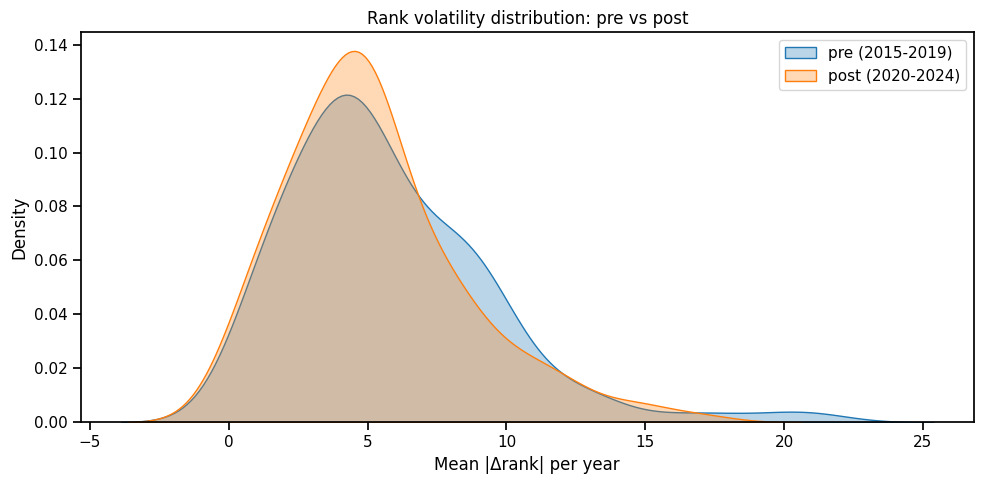

paired t-test (pre vs post volatility): TtestResult(statistic=np.float64(1.611898500127328), pvalue=np.float64(0.10918894585843883), df=np.int64(143))


In [8]:
panel_rank_df = happiness_df.pivot_table(index="country", columns="year", values="rank", aggfunc="mean")

pre_years = [2015, 2016, 2017, 2018, 2019]
post_years = [2020, 2021, 2022, 2023, 2024]

def mean_rank_jump(panel_df: pd.DataFrame, years: list[int]) -> pd.Series:
    """
    pivot된 rank 패널 데이터(panel_df)에서 선택한 years 구간의 평균 순위 점프(|Δrank|)를 계산한다.

    Parameters
    ----------
    panel_df : pd.DataFrame
        index=country, columns=year, values=rank 형태의 패널 데이터.
    years : list[int]
        계산에 사용할 연도 리스트(정렬된 상태 권장).

    Returns
    -------
    pd.Series
        국가별 mean |Δrank| 값.
    """
    diff_df = panel_df[years].diff(axis=1).abs()
    return diff_df.mean(axis=1, skipna=True)

vol_pre_s = mean_rank_jump(panel_rank_df, pre_years)
vol_post_s = mean_rank_jump(panel_rank_df, post_years)

delta_vol_df = pd.DataFrame({
    "country": vol_pre_s.index,
    "pre_vol": vol_pre_s.values,
    "post_vol": vol_post_s.values,
})
delta_vol_df["delta_vol(post-pre)"] = delta_vol_df["post_vol"] - delta_vol_df["pre_vol"]
delta_vol_df = delta_vol_df.dropna()

display(delta_vol_df.sort_values("delta_vol(post-pre)", ascending=False).head(15))

plt.figure(figsize=(10, 5))
sns.kdeplot(delta_vol_df["pre_vol"], label="pre (2015-2019)", fill=True, alpha=0.3)
sns.kdeplot(delta_vol_df["post_vol"], label="post (2020-2024)", fill=True, alpha=0.3)
plt.title("Rank volatility distribution: pre vs post")
plt.xlabel("Mean |Δrank| per year")
plt.legend()
plt.tight_layout()
plt.show()

paired_tt = stats.ttest_rel(delta_vol_df["pre_vol"], delta_vol_df["post_vol"], nan_policy="omit")
print("paired t-test (pre vs post volatility):", paired_tt)